## Explore that parameter space!

[useful to test my intuition](http://jackterwilliger.com/biological-neural-networks-part-i-spiking-neurons/)

## 1 Setup & params

In [8]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import pandas as pd
import os
import json
import time # to track how long simulation takes
import timeit
import itertools
import numpy as np
from importlib import reload # to reload the module when making changes
from itertools import permutations # for creating the permutations
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
# horay for beautiful plots
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
sns.set_palette("coolwarm")
# set the path 
path = 'data/'

# seed 
np.random.seed(0)

import SimulationClass as simu

# update changes made in python script
reload(simu);

## SIMULATION ##
simtime = 1000. # simulation time
stim_start = 0.    # start time of dc 
stim_end = 150.  # end time of dc 
N_total = 1200 # total number of neurons

In [9]:
H = simu.HelperFuncs()

In [10]:
patterns = []
# make permutations for 8 bit pattern
for perm in H.make_permutations():
    patterns.append(perm)

## Functions

In [2]:
def set_params(leaky_g=16.7):
    
    # general simulation parameters
    sim_params = {

        'N_total':1200,
        'J_ex':6.,
        'J_in':-95.,
        'eps':0.1,  # connection probability
        'resolution':0.1,  # temporal resolution of simulation in ms. Kumar2008: 0.1
        'delay':1.5,  # synaptic delay in the network
        'n_threads':8,
        'stim_start':0., # start applying current (dc)
        'stim_end':150., # end applying current (dc)
        'simtime':1000., # simulation time 
        'sub_fr':0.9, # subthreshold current amplitude
        'sup_fr':1.01, # suprathreshold current amplitude
    }
    
    # set neuron parameters
    neuron_params = {
        'C_m': 250.0,
        'E_L': -70.0,
        'E_ex': 0.0,
        'E_in': -80.0,
        'I_e': 0.0,
        'V_reset': -70.0,
        'V_th': -50.0,
        'g_L': 16.7,
        't_ref': 2.0,
        'tau_syn_ex': 0.326,
        'tau_syn_in': 0.326,
    }
    
    # change conductance
    neuron_params['g_L'] = leaky_g
    
    return sim_params, neuron_params

In [3]:
def simulate(patterns, sim_params, neuron_params):
    
    # initialise classes
    udp = simu.UpDownPatterns(sim_params, neuron_params)
    
    # make lists
    spike_times_lst = []
    spike_neurons_lst = []
    multimeters = []
    spikedetectors = []

    # time duration
    start = time.time()

    for i, pattern in enumerate(patterns):
        label = H.list2str(pattern)
        multimet, spikedet, spike_times, spike_neurons = udp.simulate(pattern)

        # convert to python lists 
        spike_times.tolist()
        spike_neurons.tolist()

        spike_times_lst.append(spike_times)
        spike_neurons_lst.append(spike_neurons)
        multimeters.append(multimet)
        spikedetectors.append(spikedet)
        #np.savetxt(path+label, X=list(zip(spike_times, spike_neurons)))
        if i%10 == 0:
            print(f'simulation {i}: {label} done')

    end = time.time()
    print(f'That took {round(end-start)} seconds')

    # convert to np arrays
    spike_times_arr = np.array(spike_times_lst)
    spike_neurons_arr = np.array(spike_neurons_lst)
    
    return spike_times_arr, spike_neurons_arr

In [4]:
def spoon_out(spike_times_arr,spike_neurons_arr):
    
    num_transient_spikes_arr = []
    time_transient_spikes_arr = []
    transient_duration_arr = []
    unique_active_neurons = []

    for trial in range(len(spike_times_arr)):

        # select data from experiment / trial
        times = spike_times_arr[trial]
        neurons = spike_neurons_arr[trial]

        # get amount of spikes in transient for that trial
        num_trans_spikes = sum(1*(times > stim_end))
        num_transient_spikes_arr.append(num_trans_spikes)

        # select the spiketimes after the stimulation ended
        time_transient_spikes = times[times > stim_end]
        time_transient_spikes_arr.append(time_transient_spikes)

        # get the length of the transient
        if num_trans_spikes == 0:
            transient_duration_arr.append(0)
        else:
            t_dur = round(max(time_transient_spikes_arr[trial]) - stim_end,2)
            transient_duration_arr.append(t_dur)

        # get the number of unique active neurons per transient
        transients = 1*(times > stim_end)
        transient_indices = np.argwhere(transients)
        # take the neurons from these indices
        active_neurons = np.unique(neurons[transient_indices])
        unique_active_neurons.append(active_neurons)

    total_active_neurons = [len(i) for i in unique_active_neurons]
    
    return num_transient_spikes_arr, transient_duration_arr, total_active_neurons

# Run

In [53]:
# set the parameters
sim_params, neuron_params = set_params(leaky_g=16.)

In [54]:
spike_times_arr, spike_neurons_arr = simulate(patterns,sim_params, neuron_params)

simulation 0: 11110000 done
simulation 10: 11001010 done
simulation 20: 10101010 done
simulation 30: 10010011 done
simulation 40: 01101010 done
simulation 50: 01010011 done
simulation 60: 00110011 done
That took 38 seconds


In [55]:
# call function
num_transient_spikes_arr, transient_duration_arr, total_active_neurons = spoon_out(spike_times_arr,spike_neurons_arr)

## 3 Data analysis

- seaborn `distplot` combines the matplotlib histogram with the seaborn kdeplot

In [56]:
# load in dataframe
numspikes_df = pd.DataFrame(num_transient_spikes_arr, columns=['numspikes'])
transienttime_df = pd.DataFrame(transient_duration_arr, columns=['transienttime'])
activeneurons_df = pd.DataFrame(total_active_neurons, columns=['activeneurons'])

# collect in one dataframe
data = numspikes_df.join([transienttime_df,activeneurons_df])
data = data.round(2)

In [57]:
data.mean().tolist()

[120.84285714285714, 5.417142857142857, 120.32857142857142]

In [66]:
data.describe()

,numspikes,transienttime,activeneurons
count,70.000000,70.000000,70.000000
mean,120.842857,5.417143,120.328571
std,100.644537,2.399938,99.204184
min,0.000000,0.000000,0.000000
25%,44.250000,3.700000,44.250000
50%,104.000000,5.250000,104.000000
75%,160.750000,6.950000,160.750000
max,540.000000,11.800000,531.000000


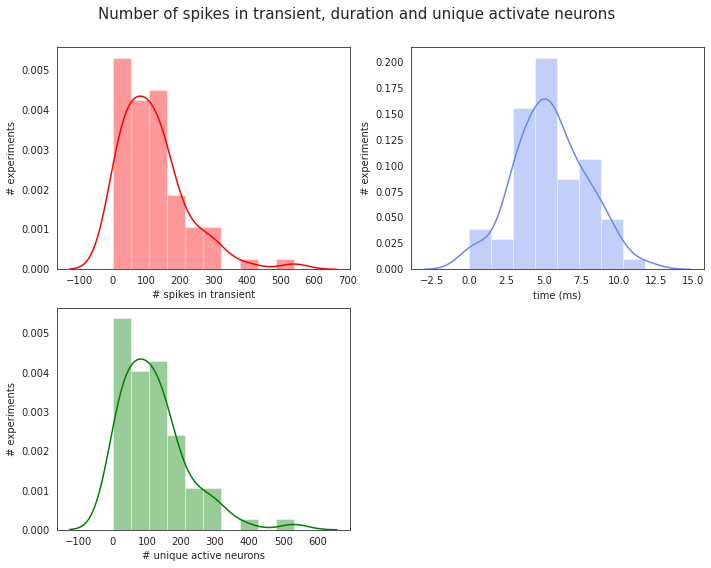

In [61]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharex=False)

sns.distplot(data['numspikes'], ax=axes[0,0], color='r');
axes[0,0].set_xlabel('# spikes in transient')
axes[0,0].set_ylabel('# experiments')

sns.distplot(data['transienttime'], ax=axes[0,1]);
axes[0,1].set_xlabel('time (ms)')
axes[0,1].set_ylabel('# experiments')

sns.distplot(data['activeneurons'], ax=axes[1,0], color='g');
axes[1,0].set_xlabel('# unique active neurons')
axes[1,0].set_ylabel('# experiments')

fig.delaxes(axes[1][1])
fig.tight_layout()
fig.subplots_adjust(top=0.91)
fig.suptitle('Number of spikes in transient, duration and unique activate neurons', size=15);

/home/nest/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


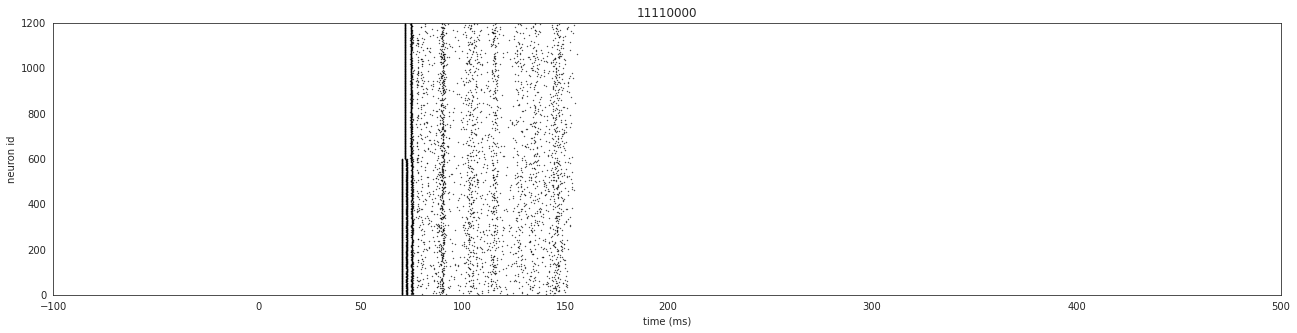

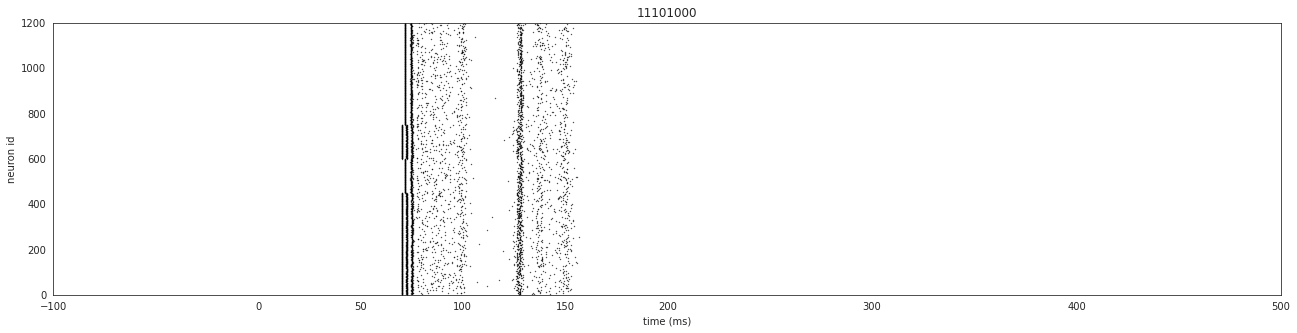

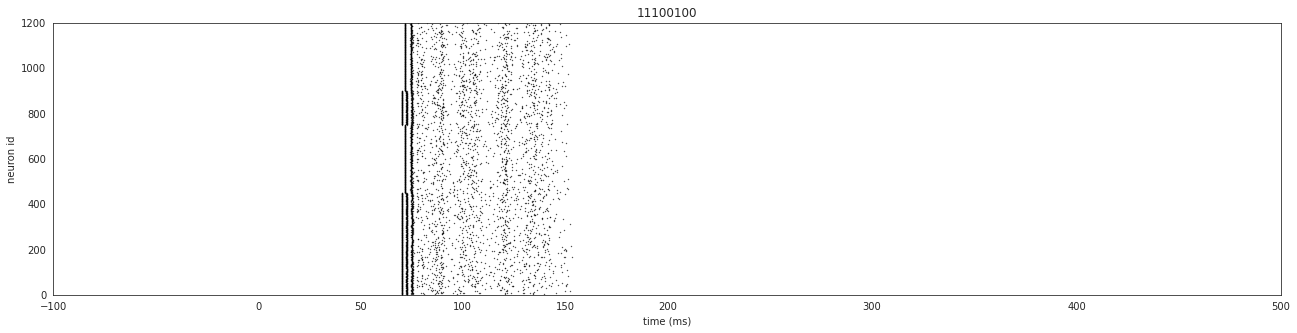

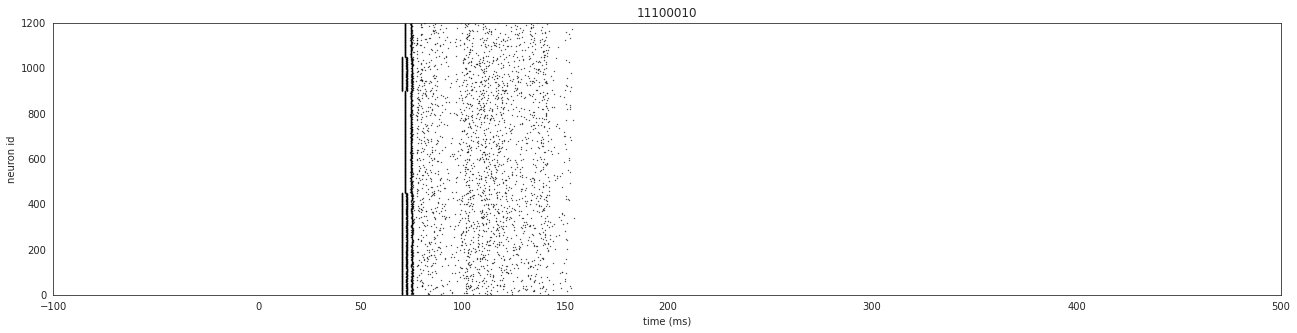

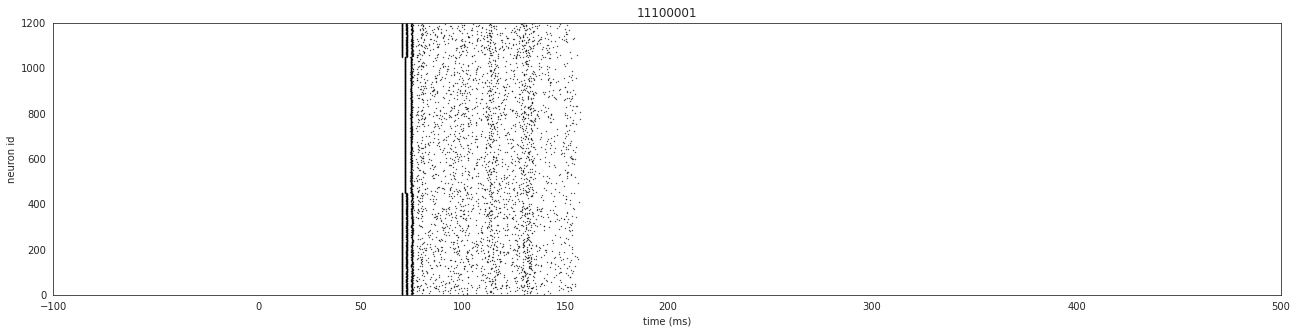

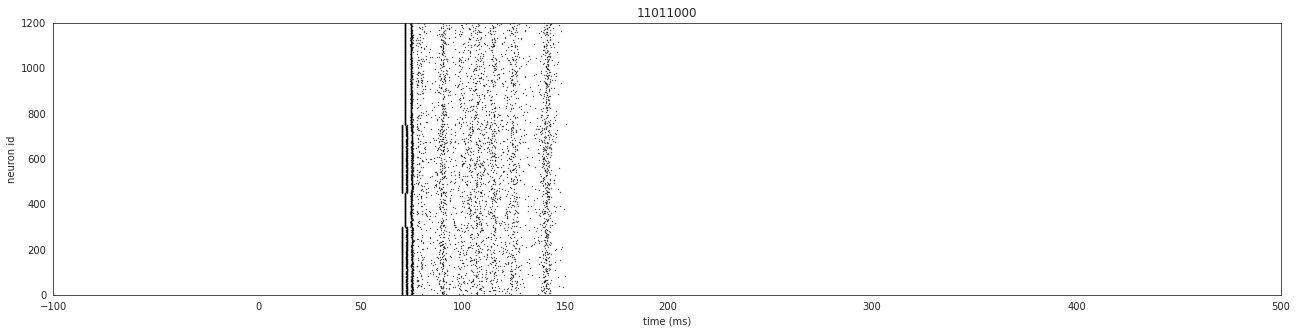

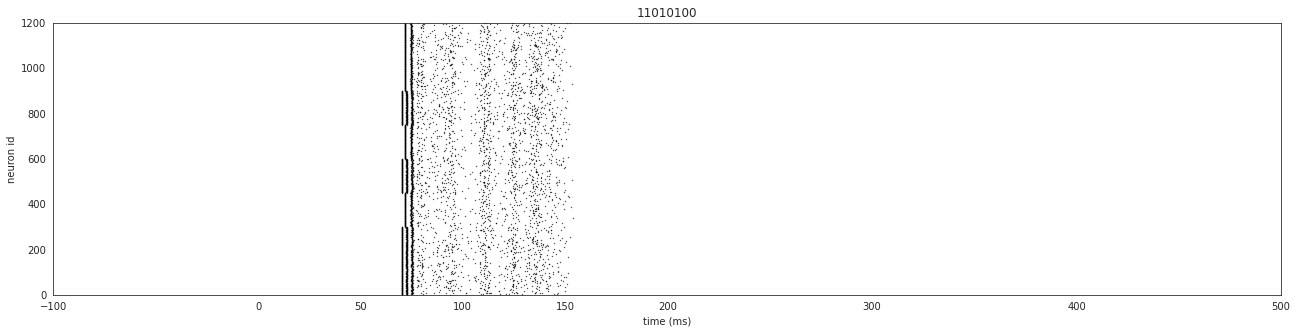

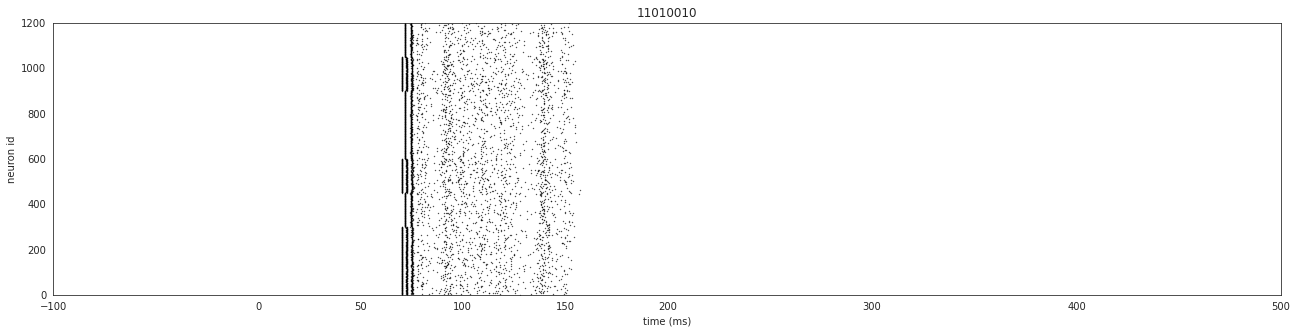

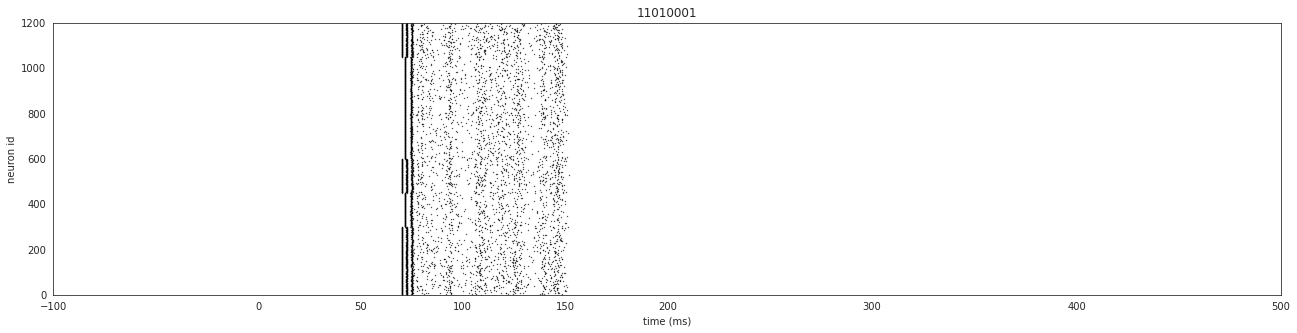

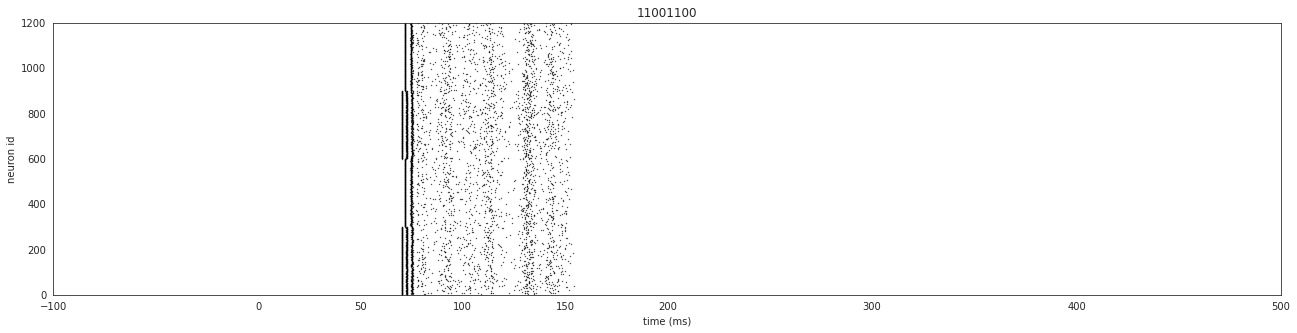

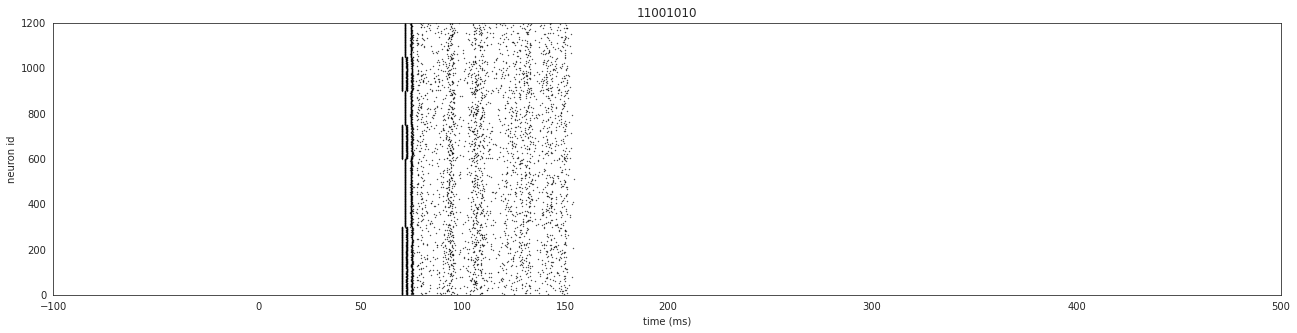

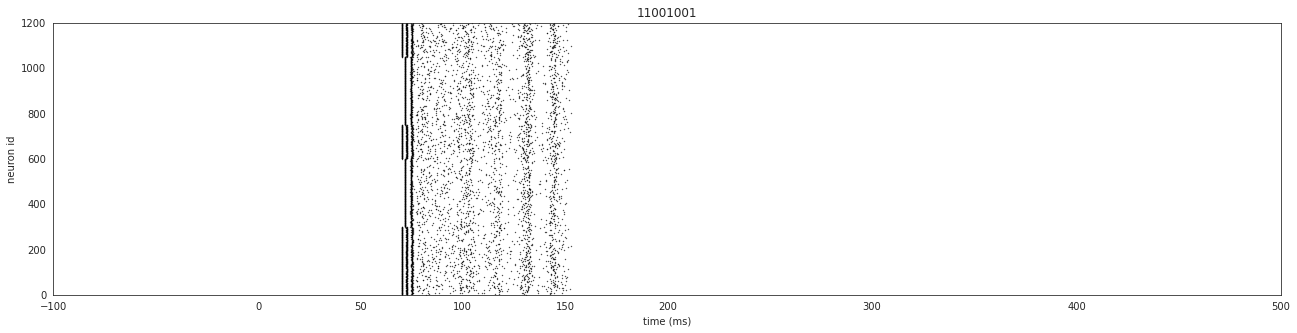

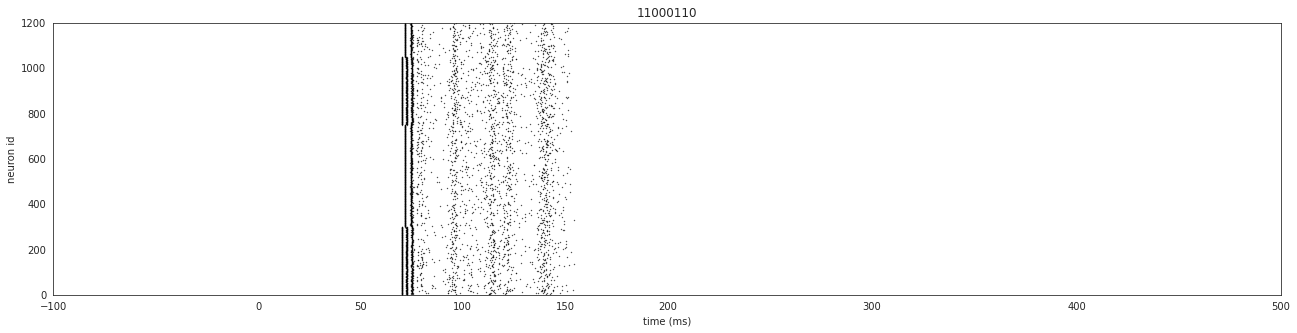

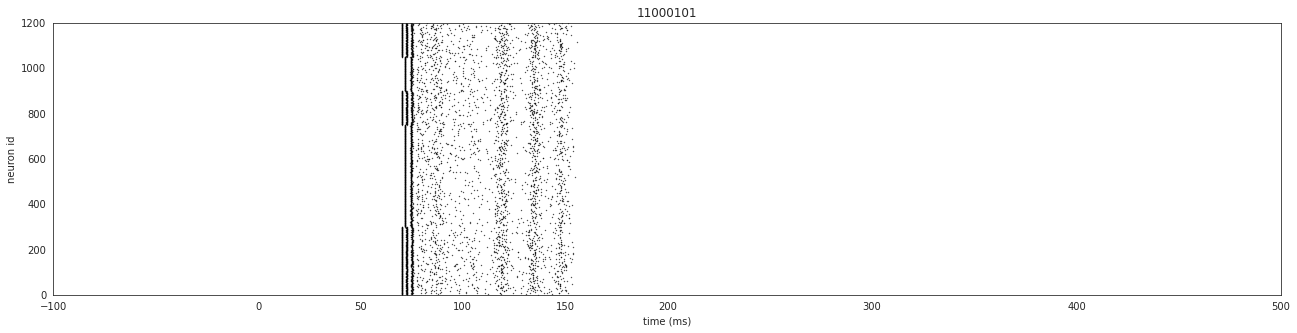

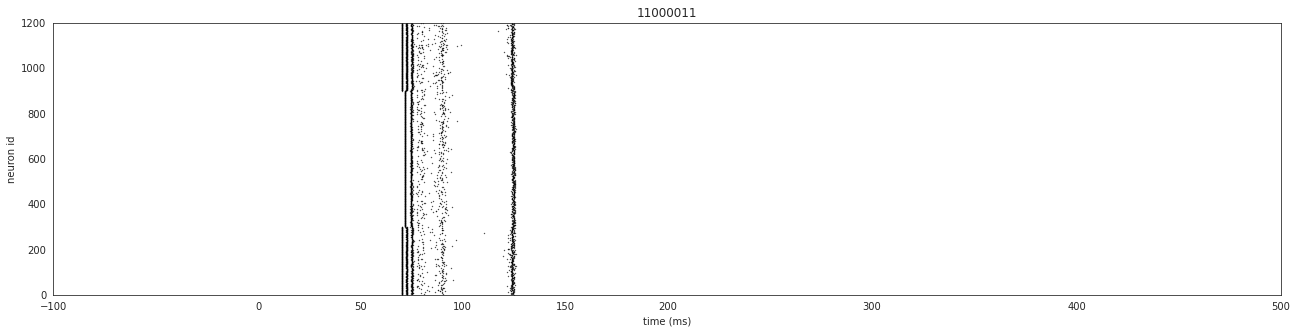

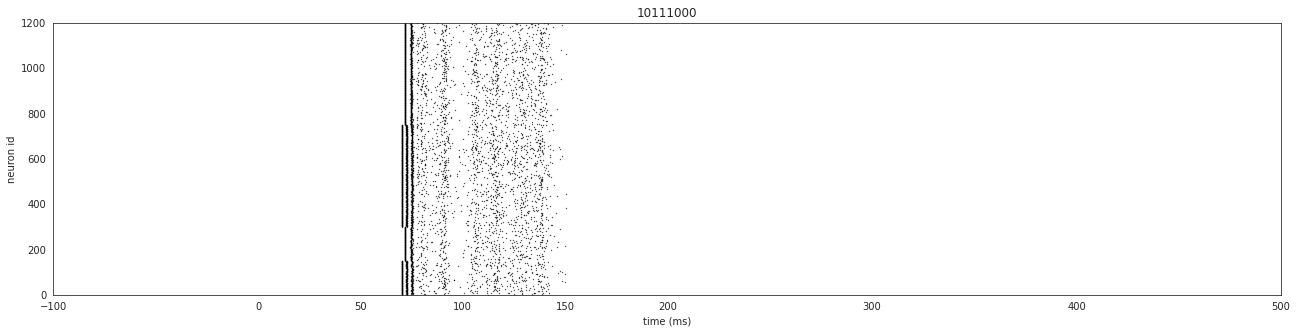

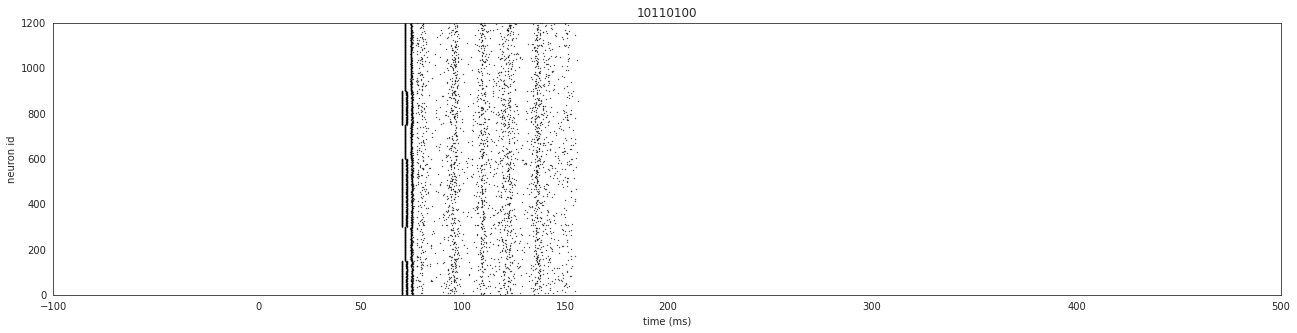

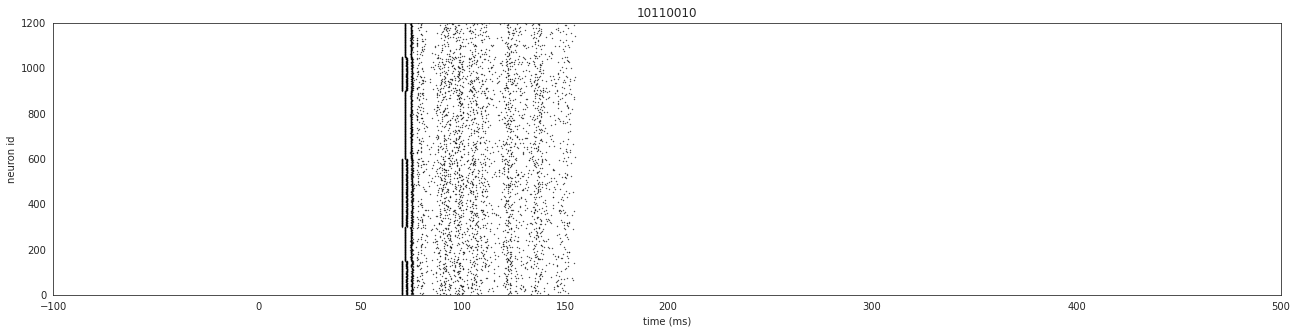

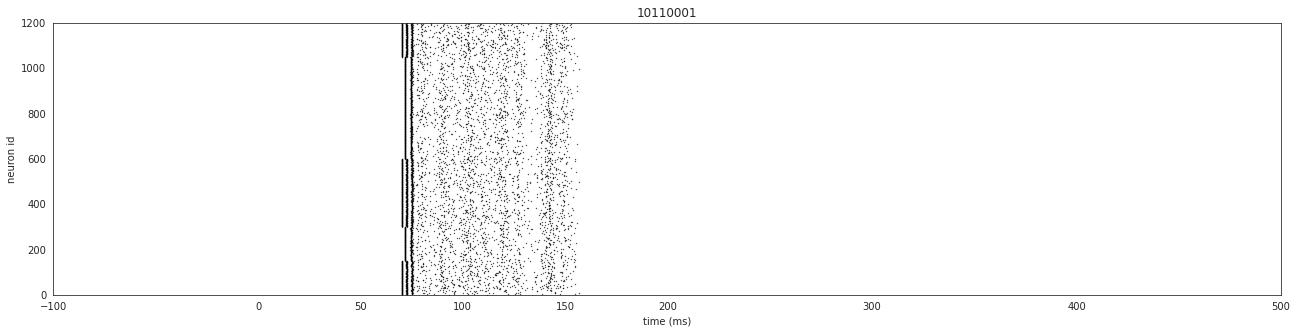

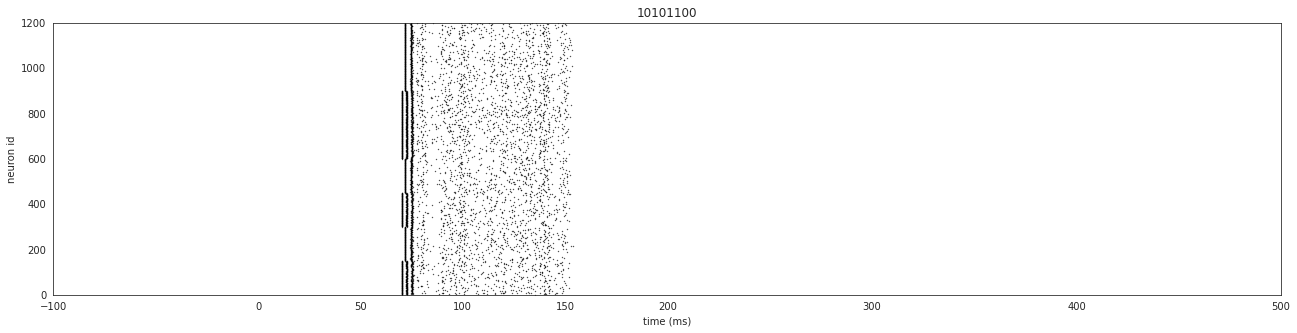

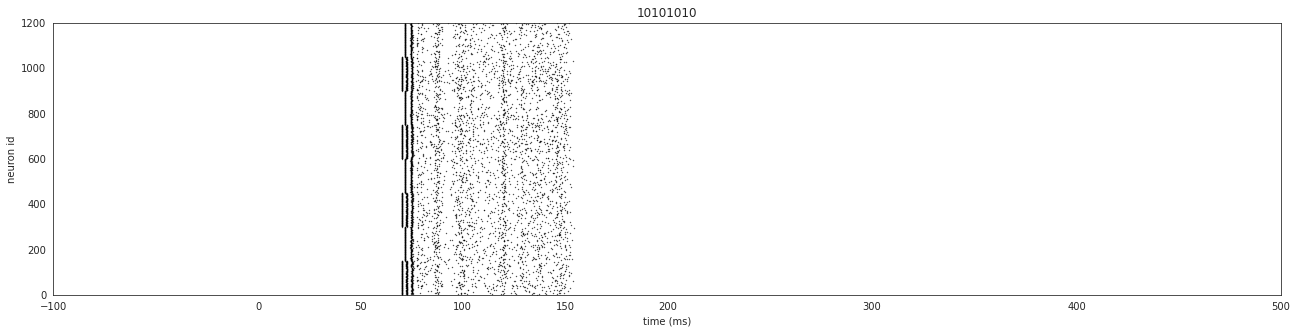

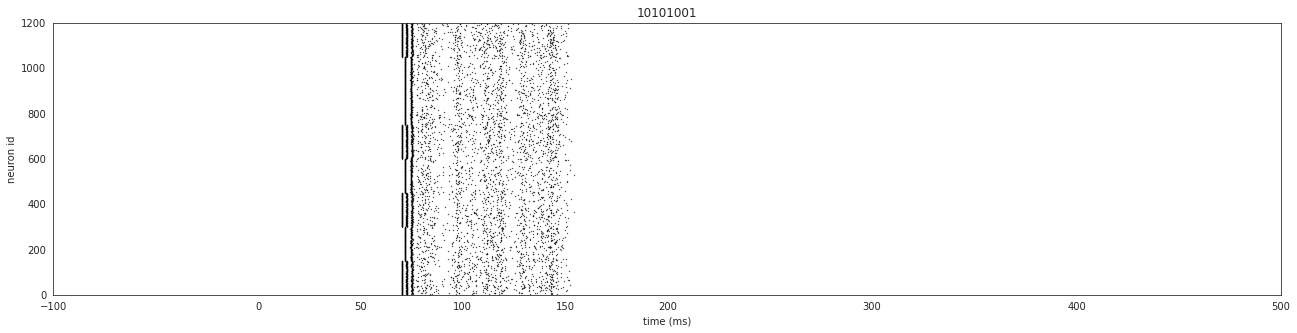

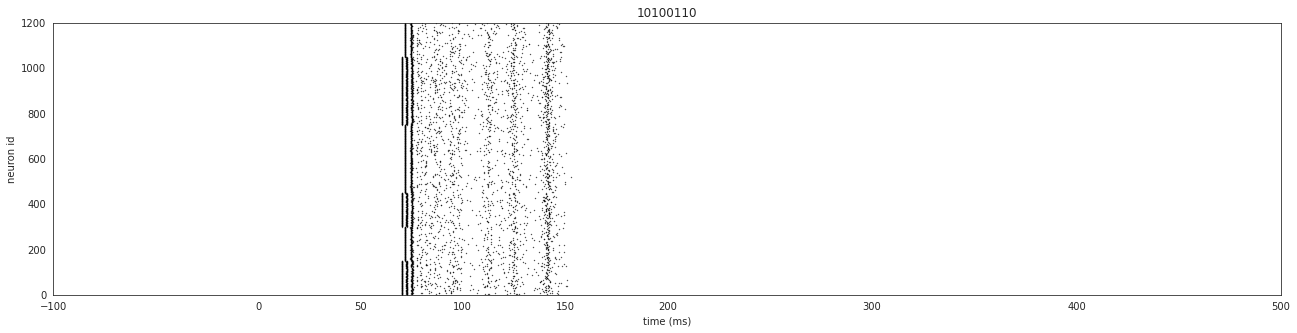

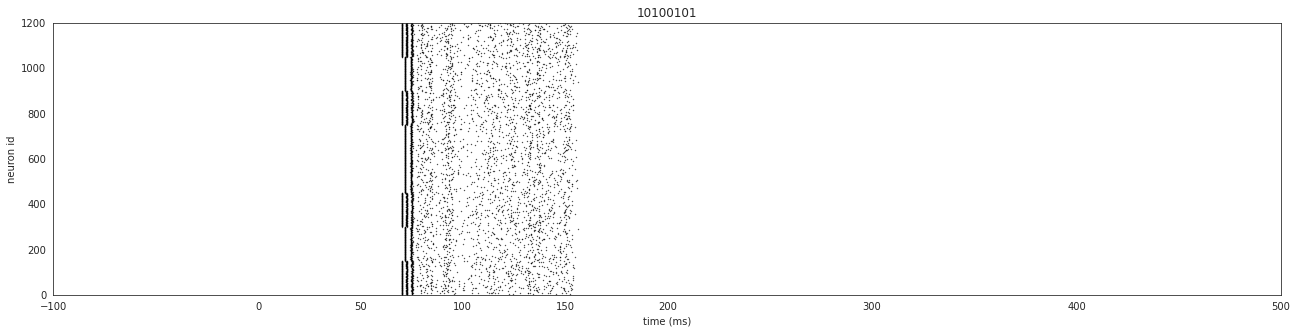

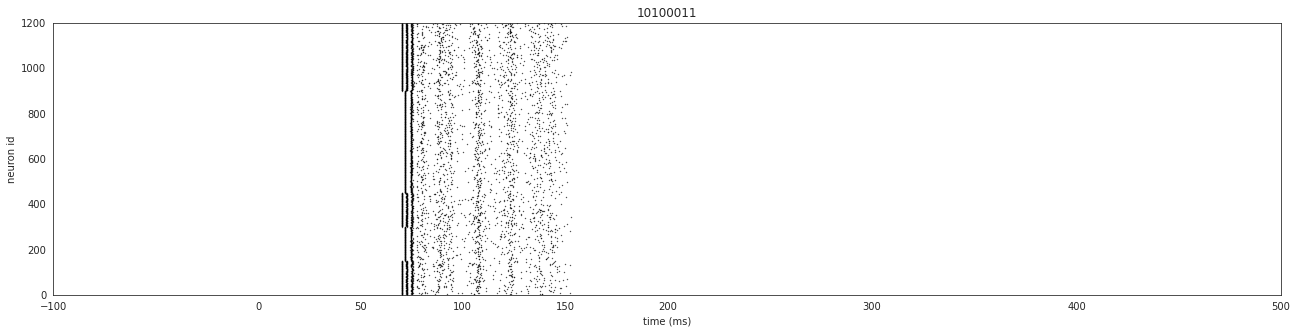

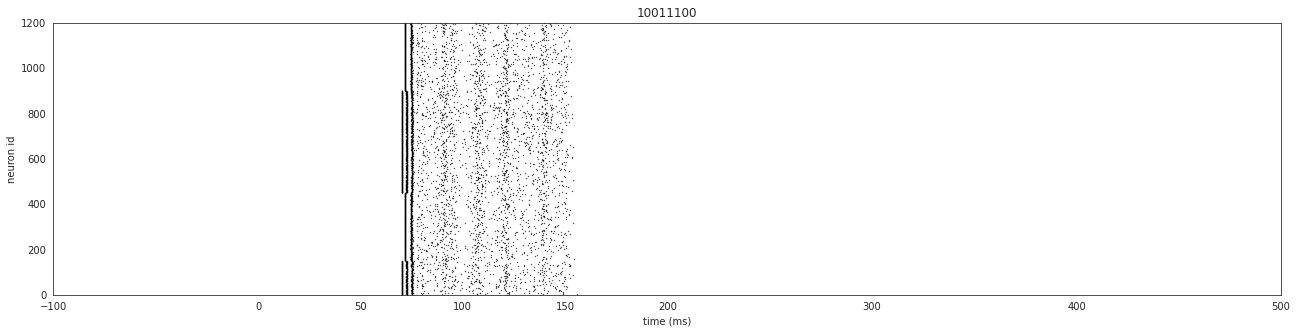

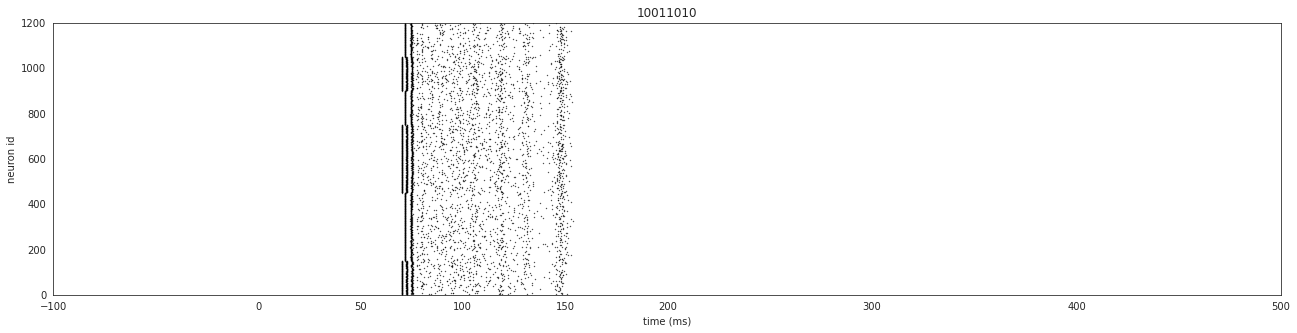

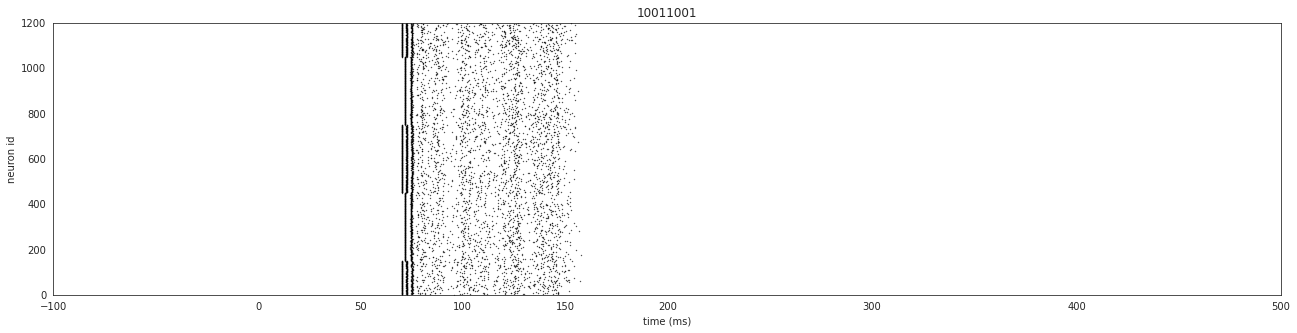

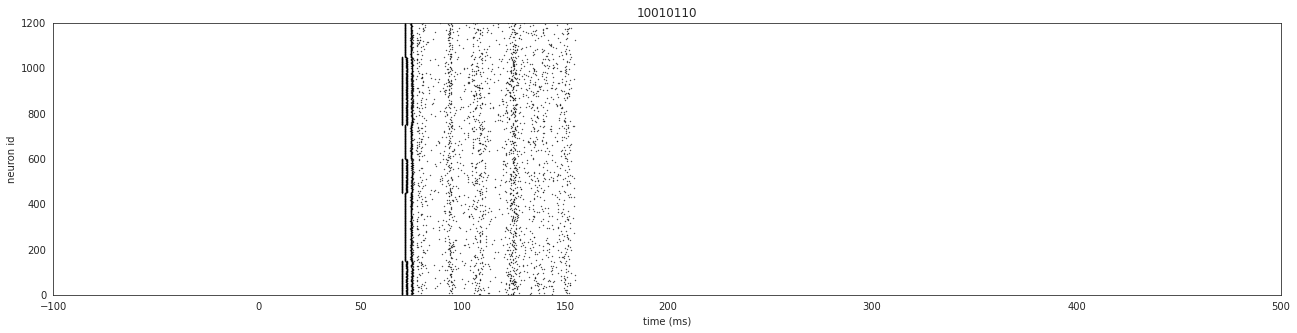

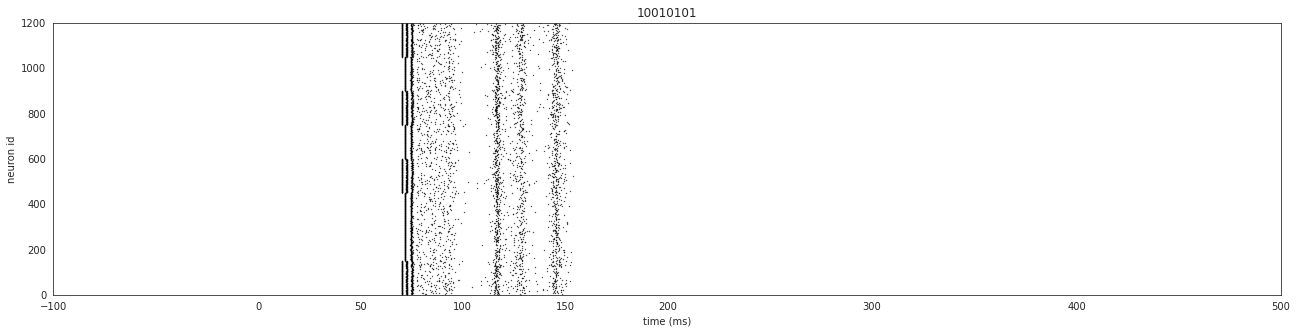

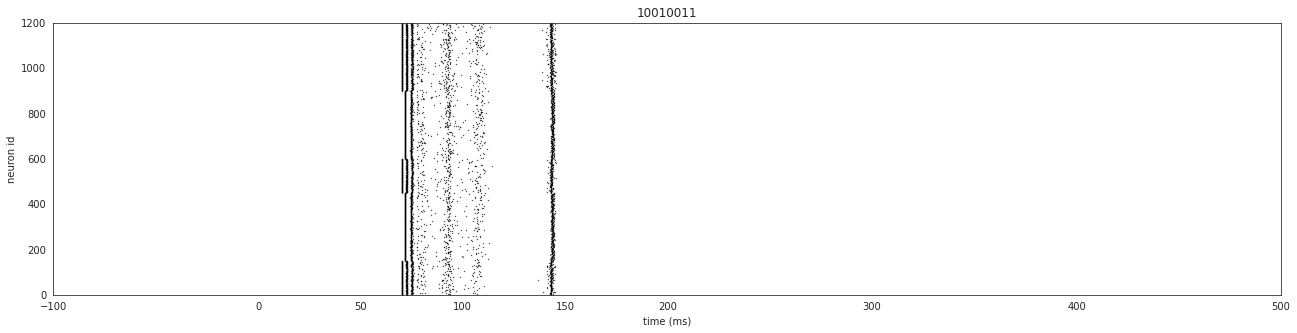

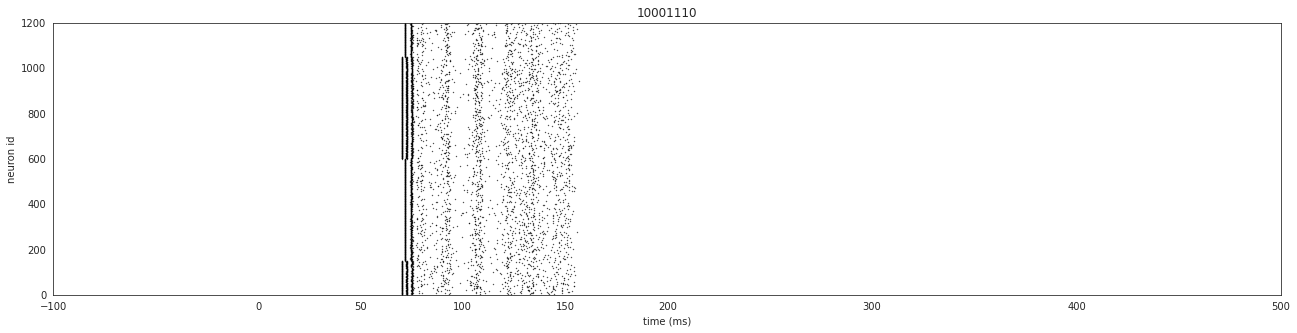

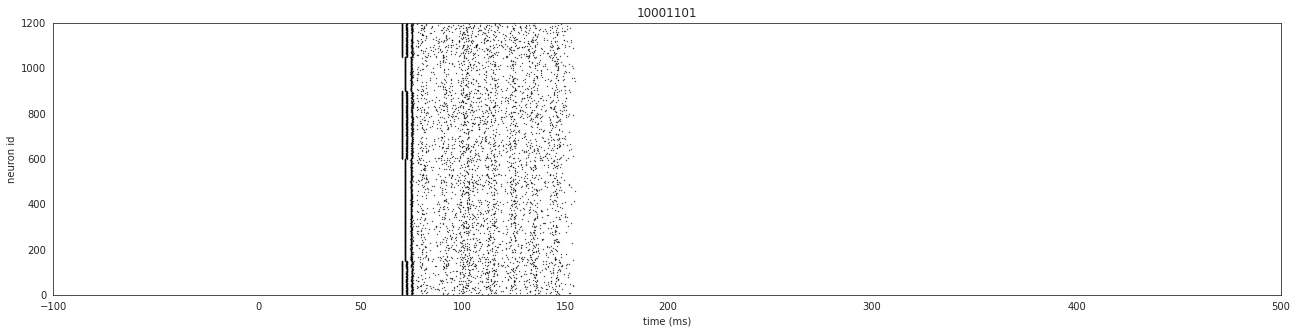

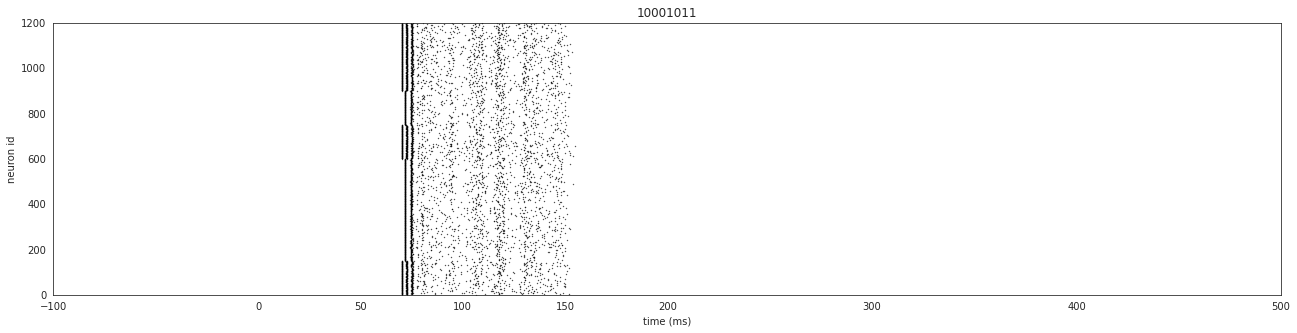

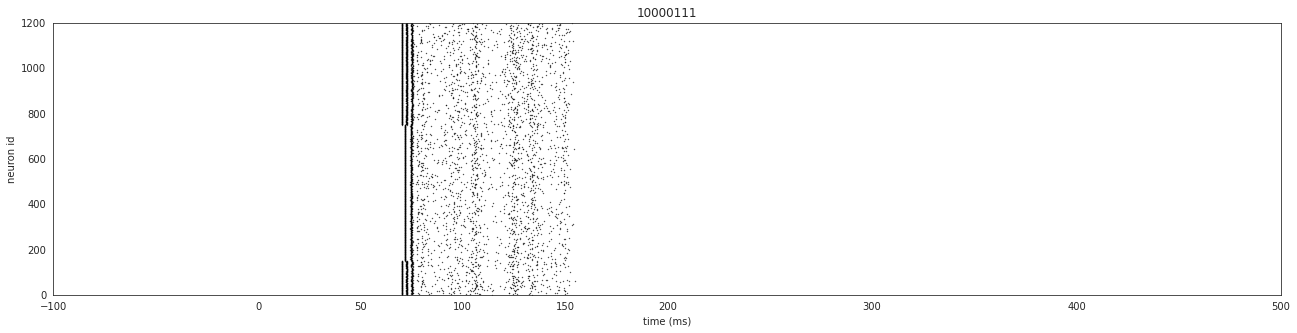

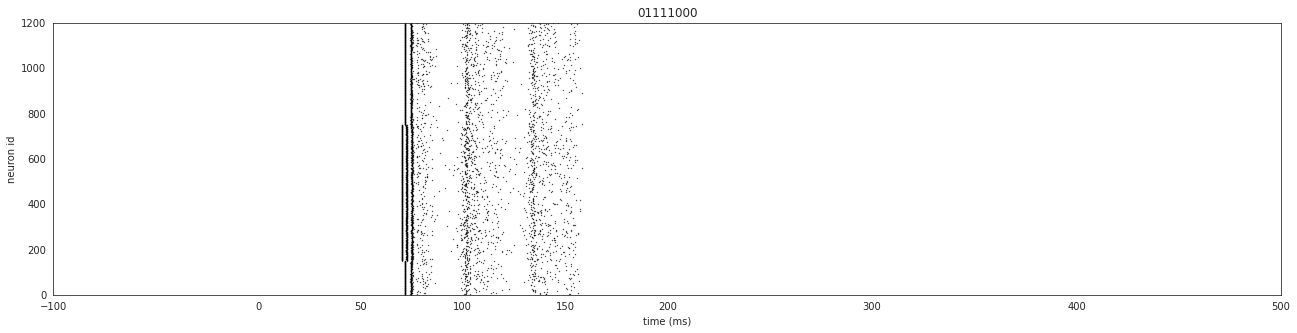

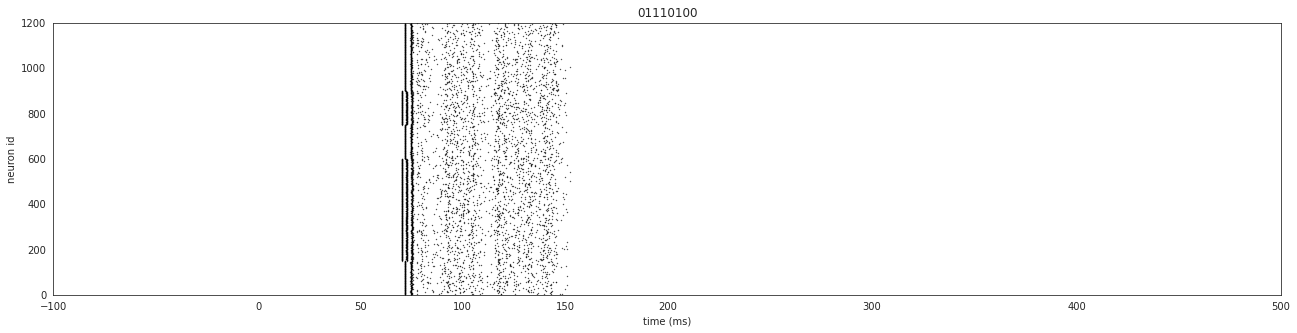

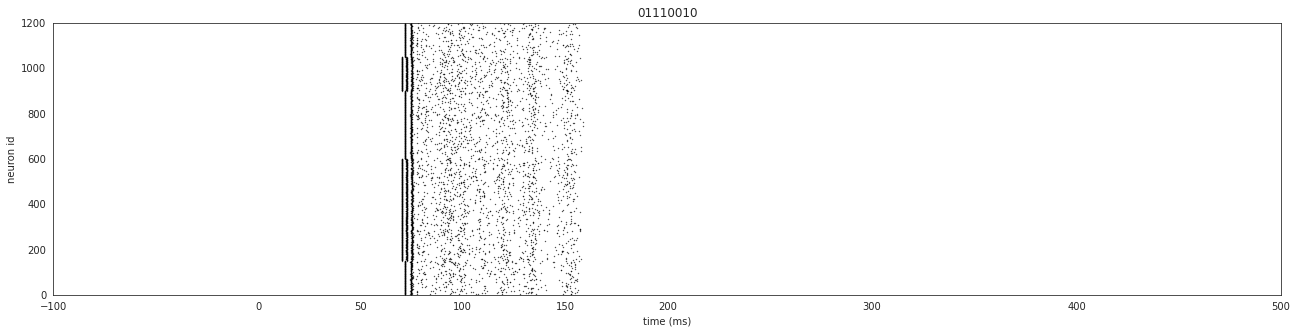

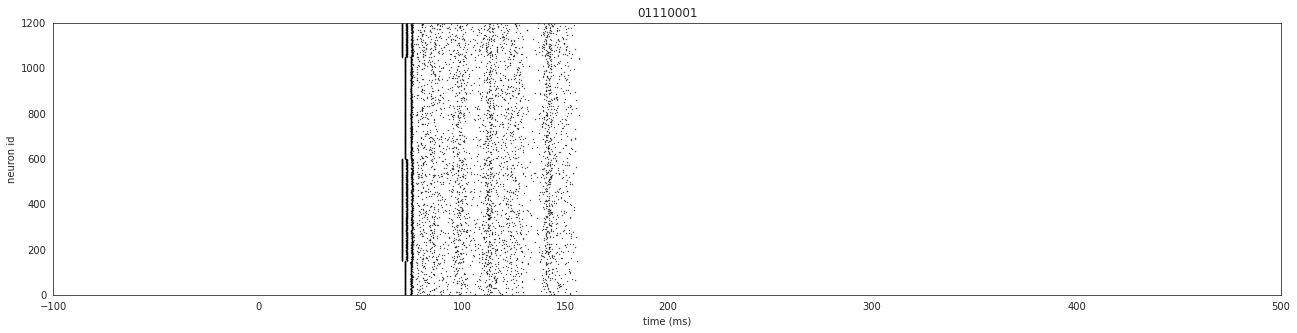

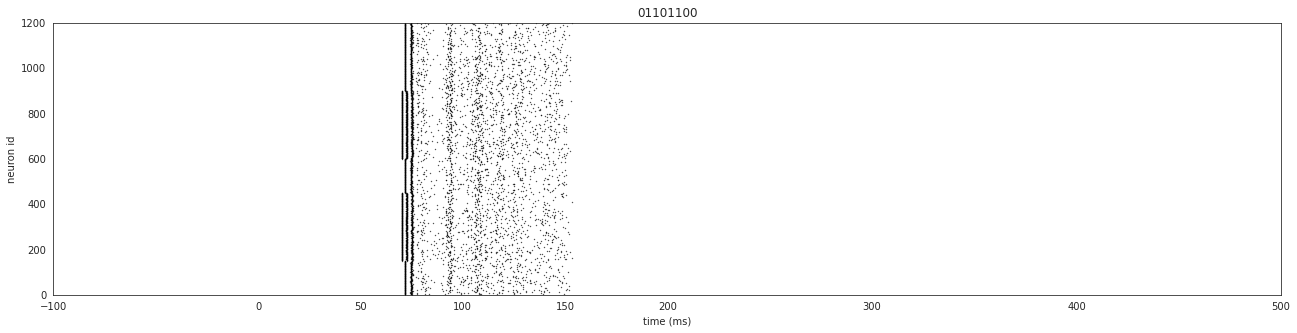

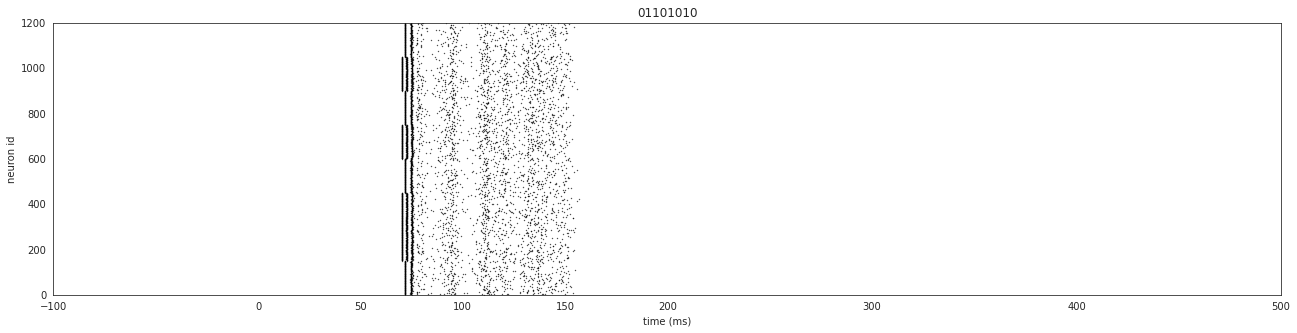

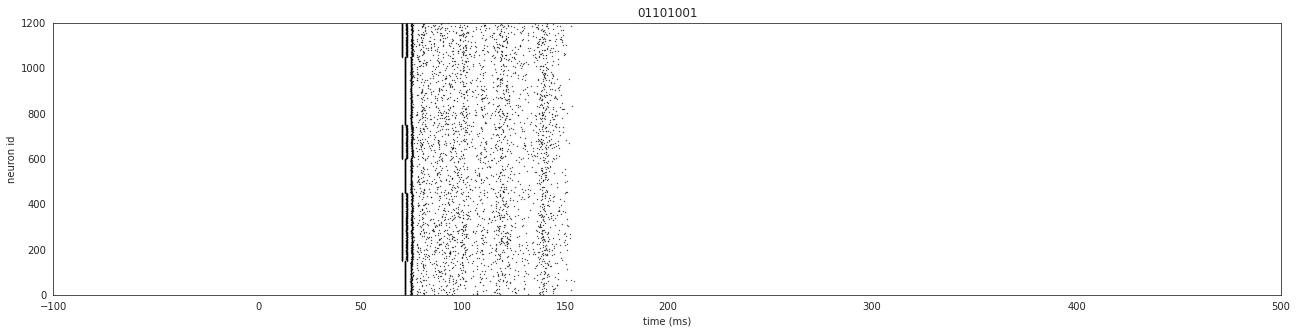

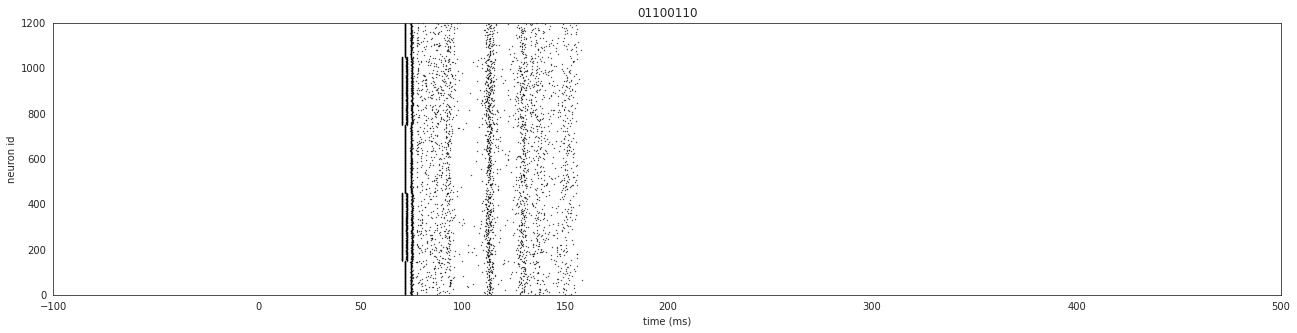

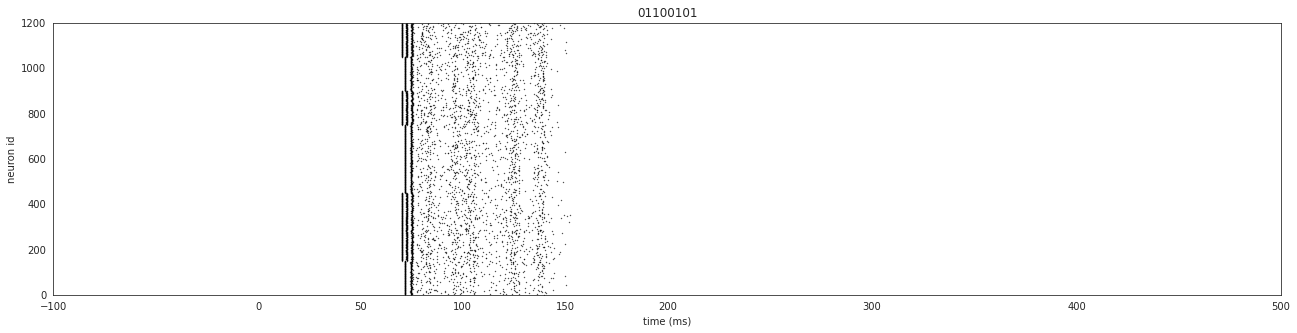

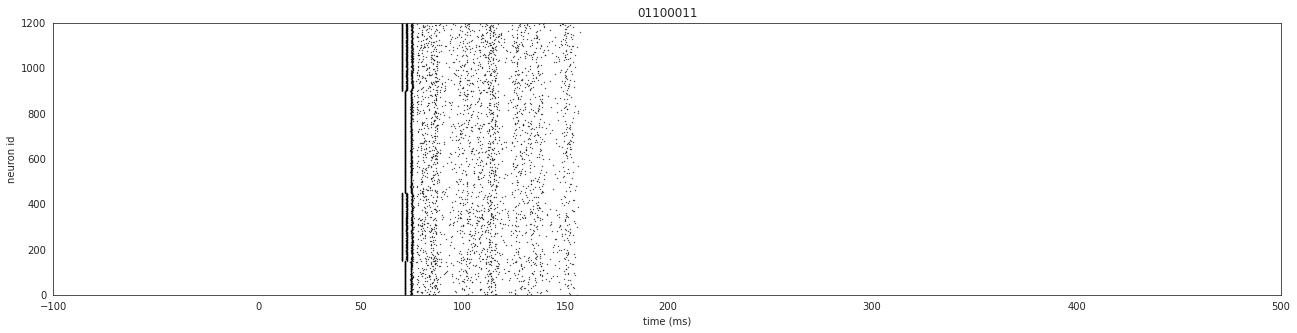

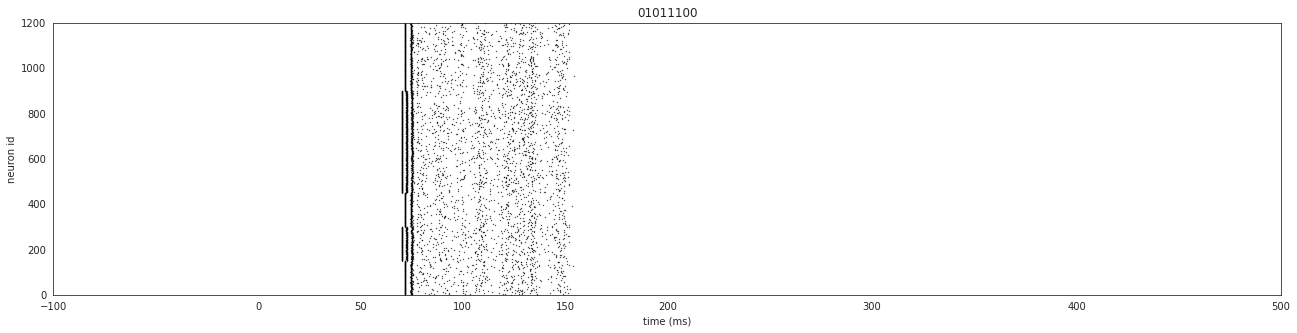

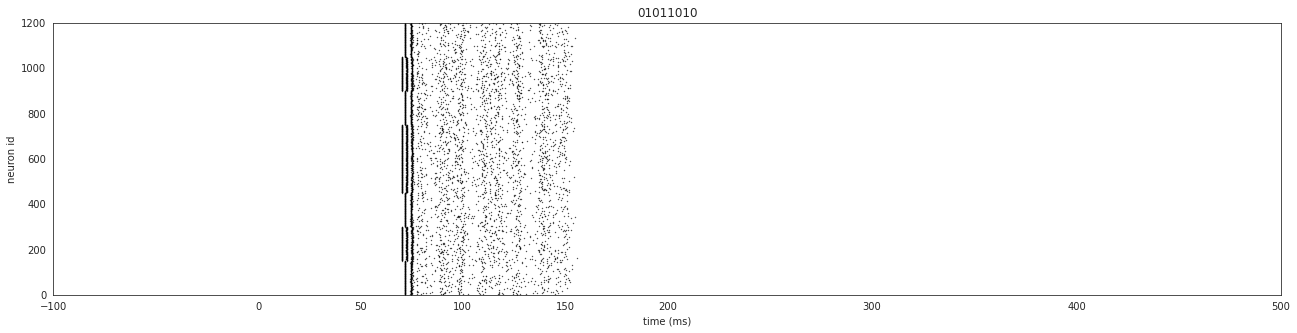

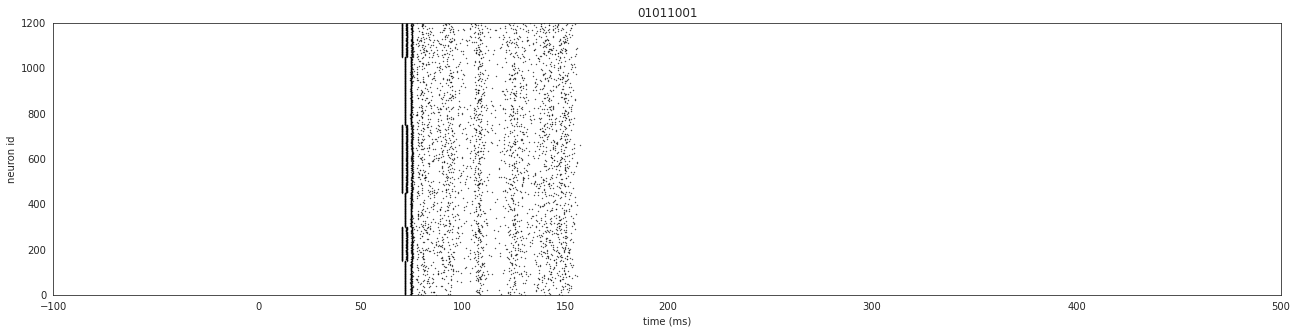

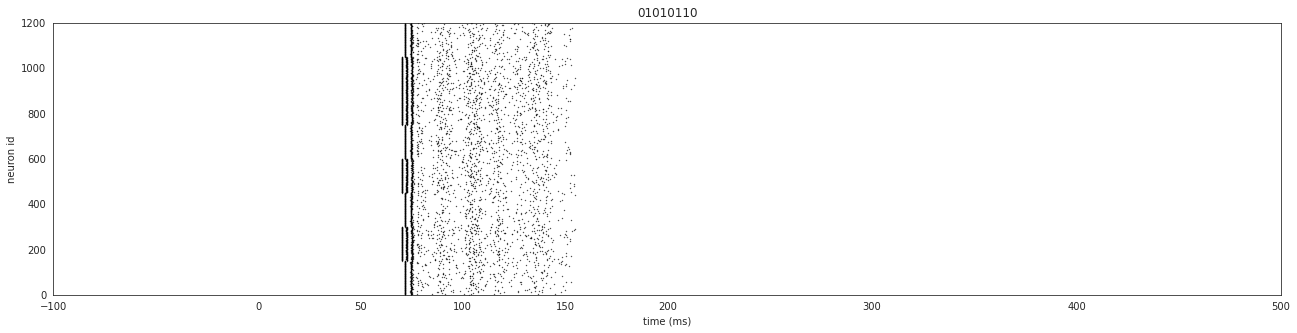

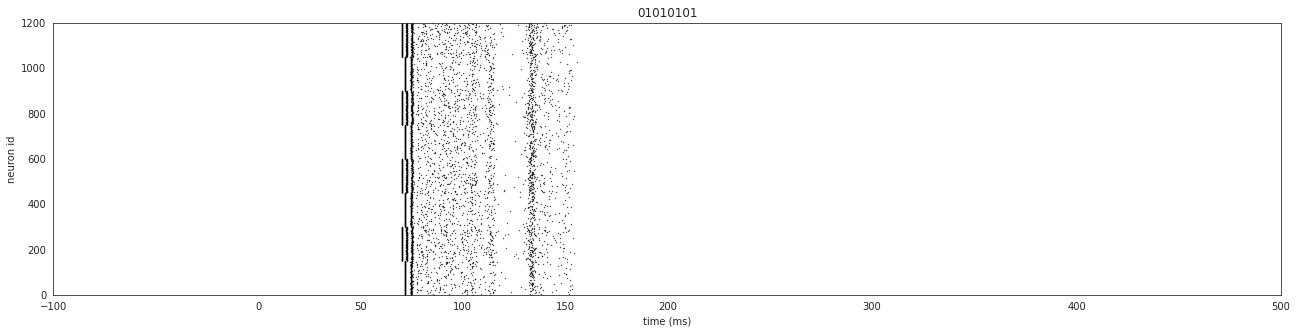

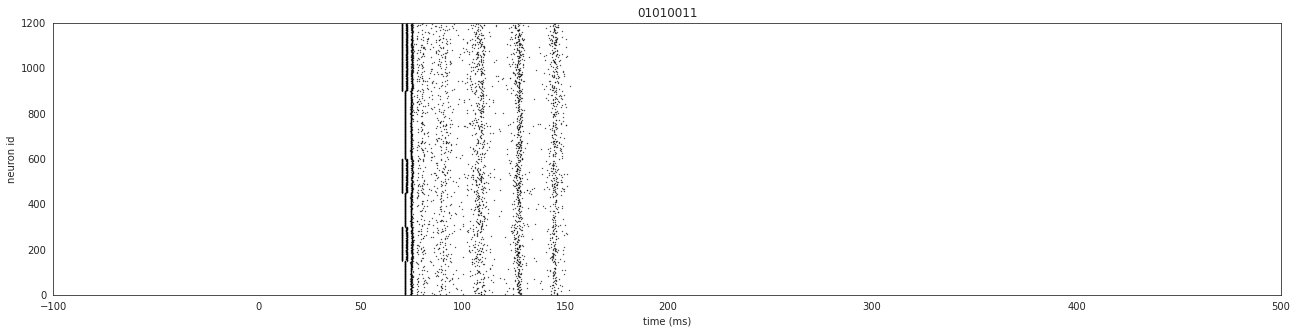

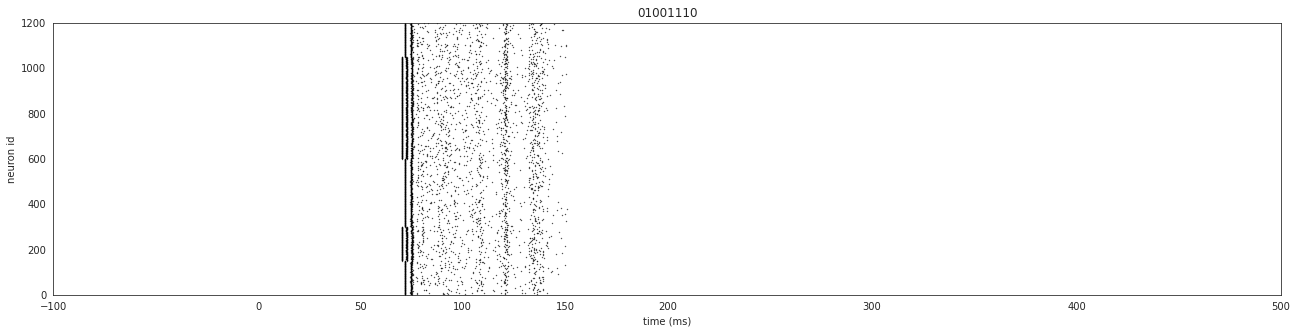

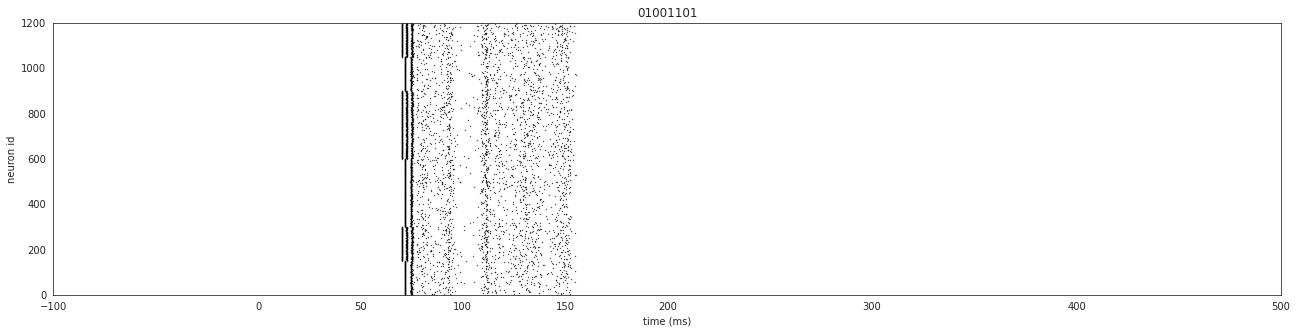

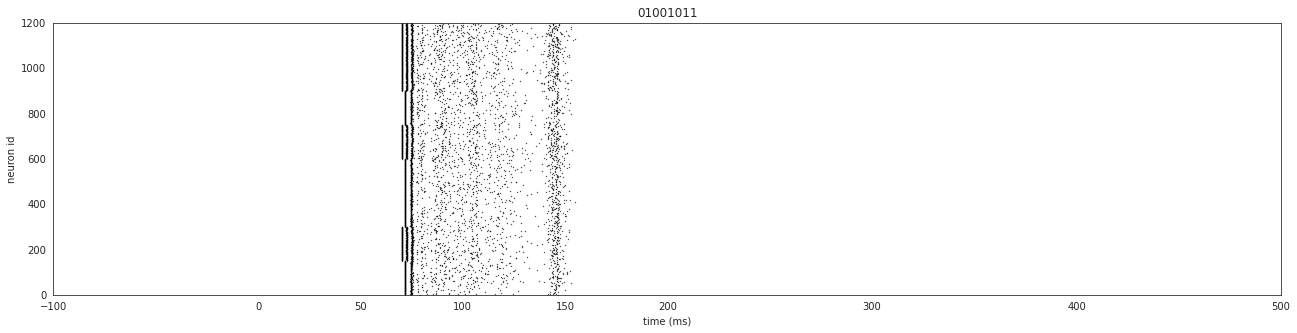

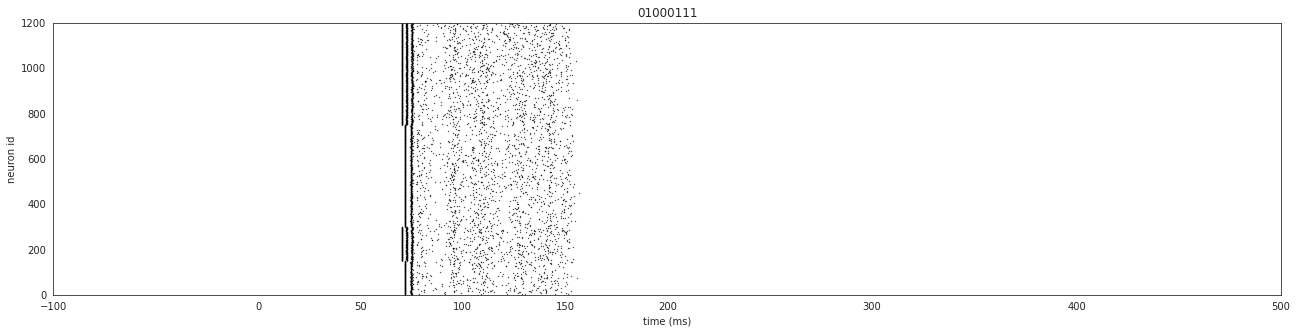

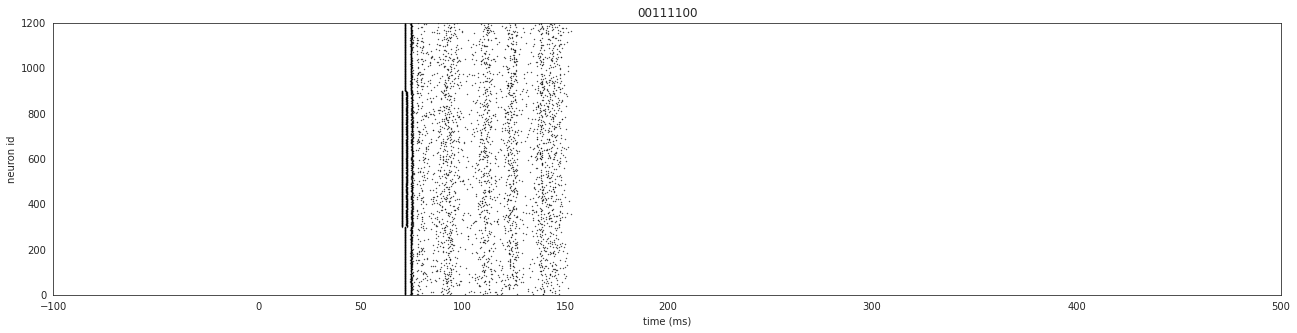

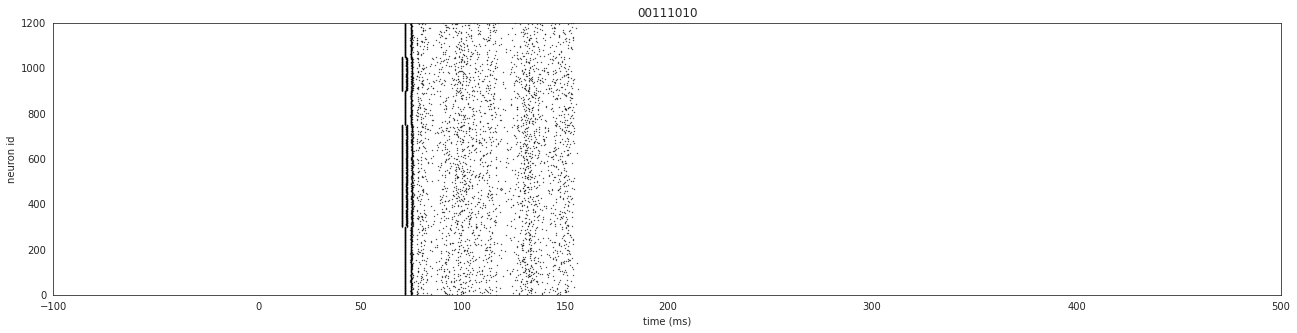

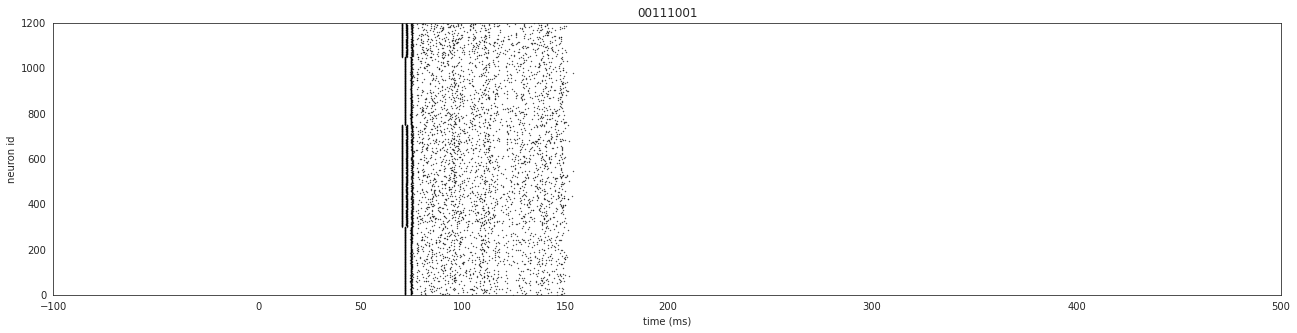

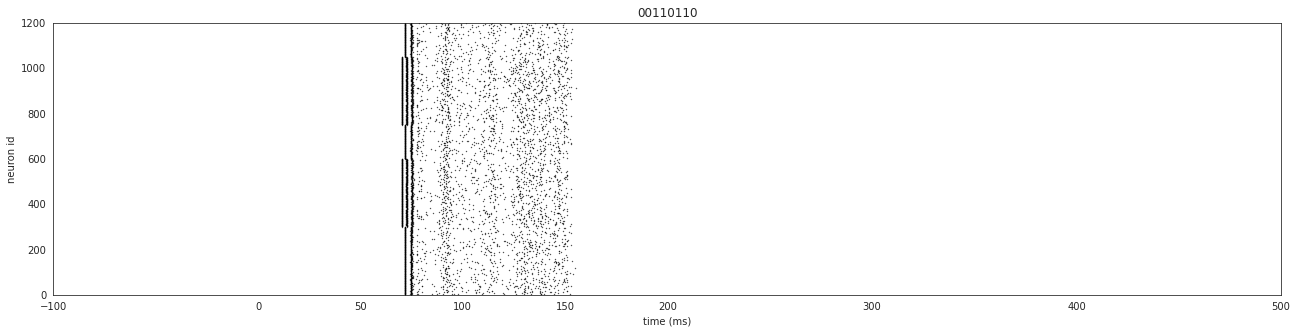

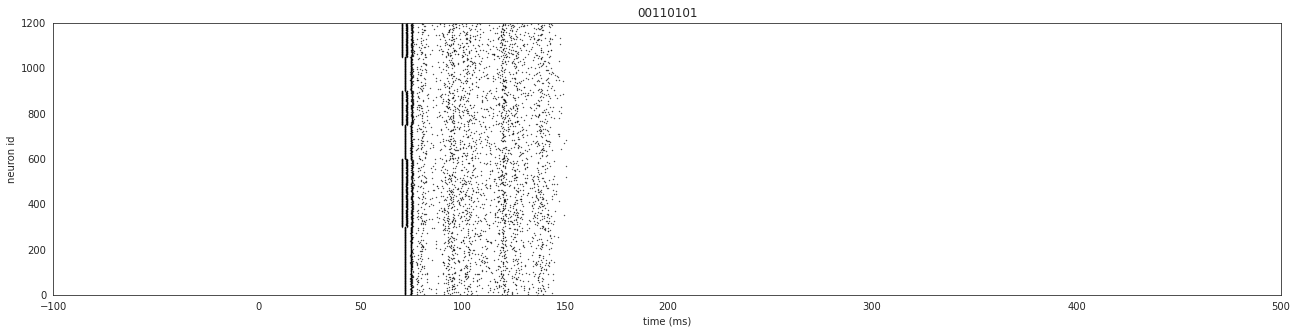

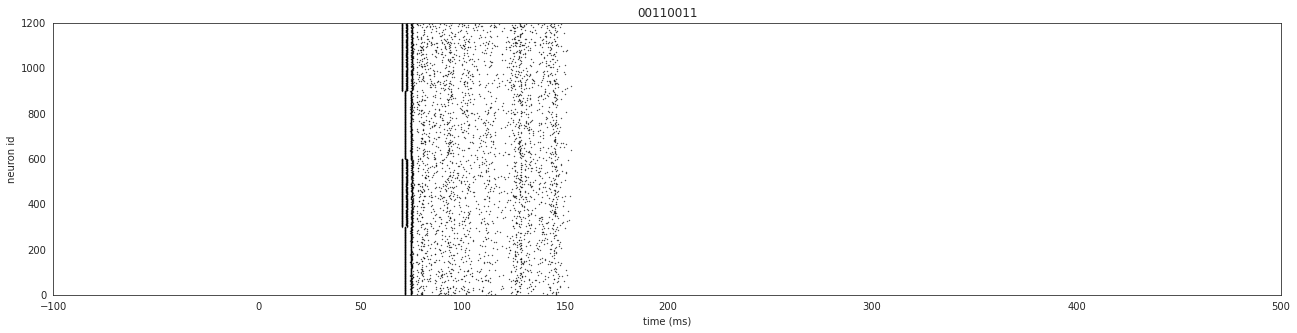

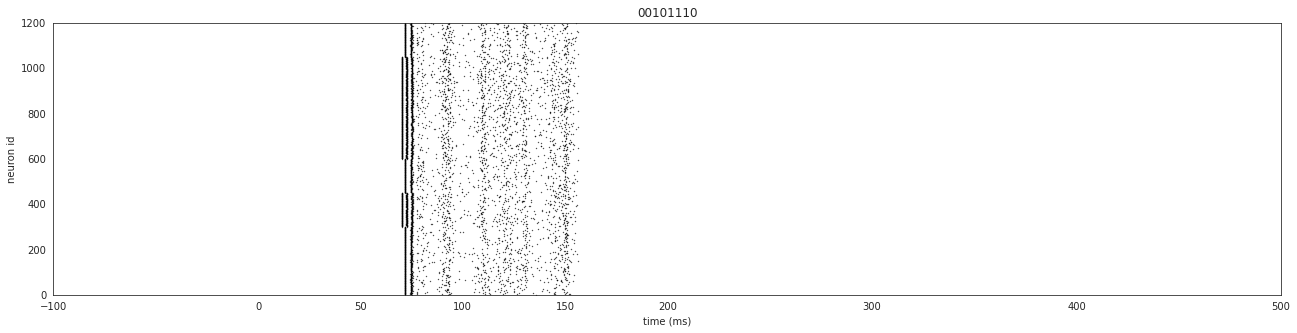

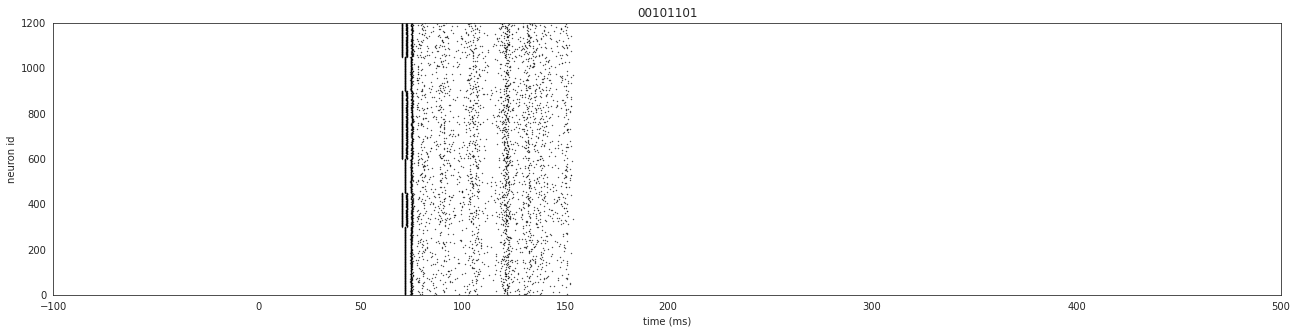

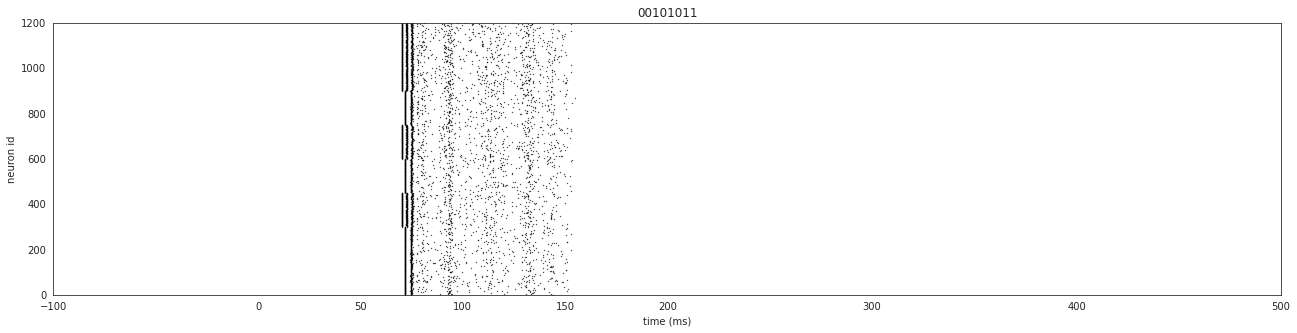

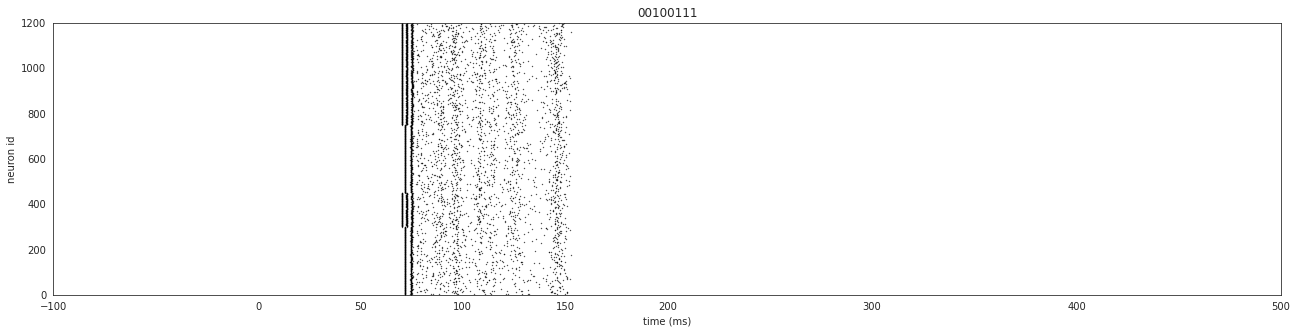

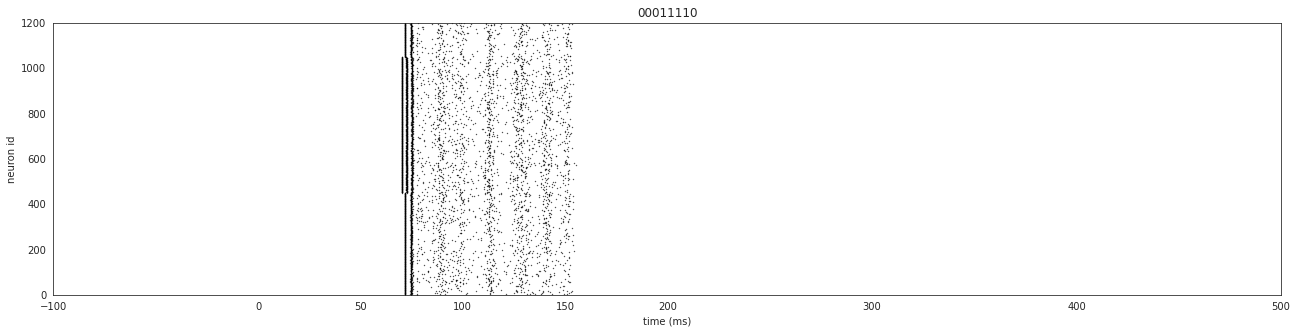

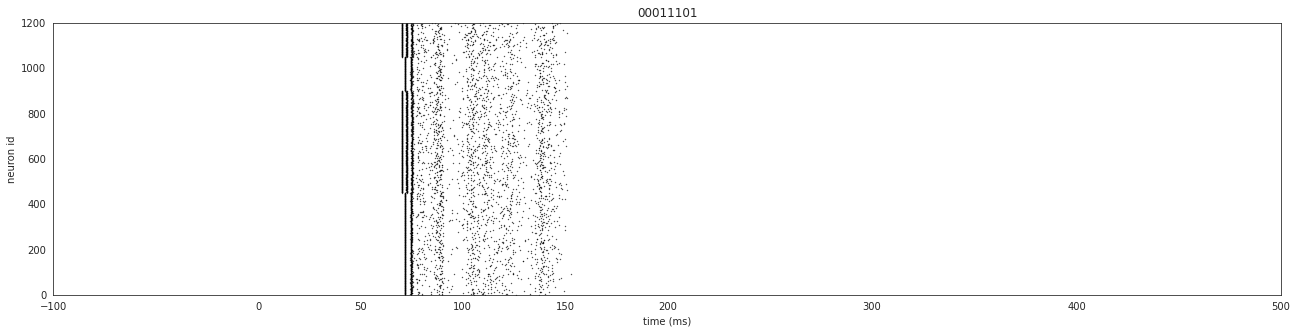

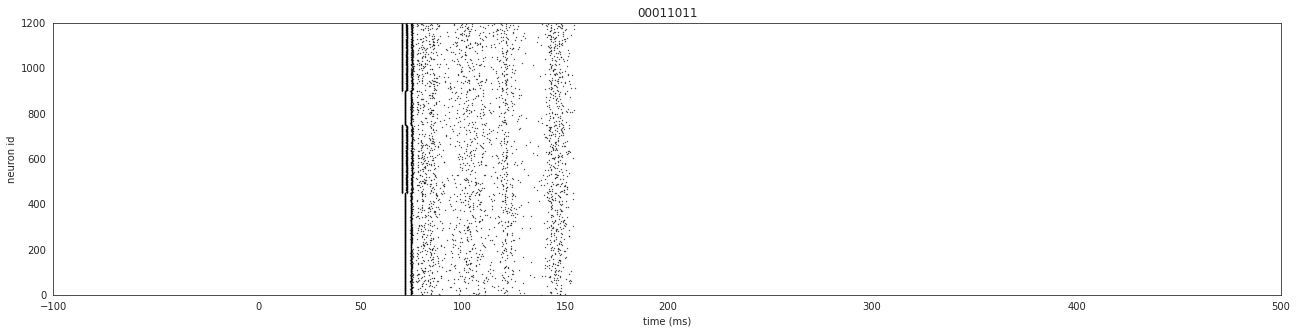

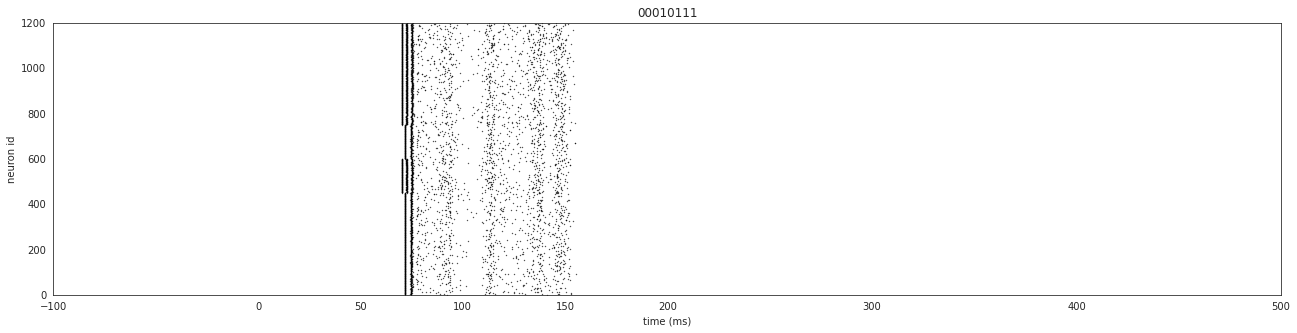

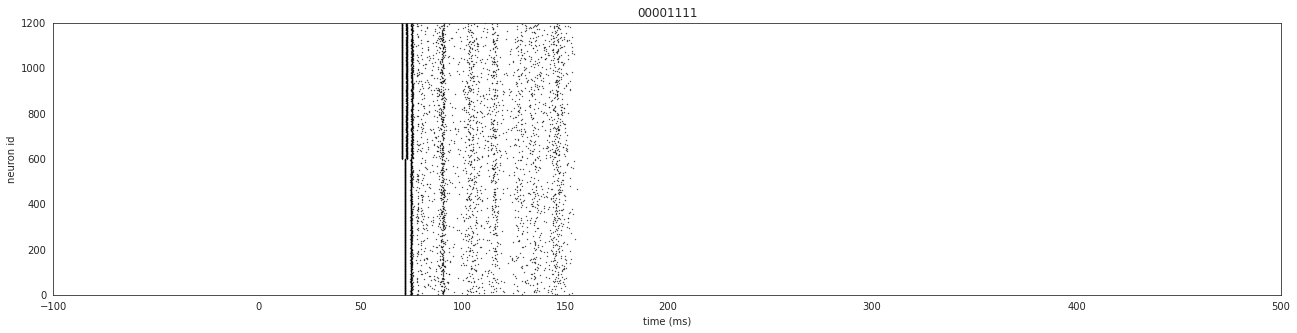

In [45]:
for i, pattern in enumerate(patterns):
    # make raster plots
    f = plt.figure(figsize=(22,5))
    
    plt.title(H.list2str(pattern))
    plt.scatter(spike_times_arr[i],spike_neurons_arr[i], marker='o', s=.1, color='k');
    plt.xlabel('time (ms)')
    plt.ylabel('neuron id')
    plt.axis([-100,500,0, N_total])
    plt.xticks(list(plt.xticks()[0]) + [50,stim_end]) # add some extra ticks for clarity
    #plt.savefig(path+str(H.list2str(pattern))) uncommment to save figures

## For range of leaky currents

In [6]:
def get_stats(transient_times, num_spikes):
    
    # load in dataframe
    df_nspikes = pd.DataFrame(num_spikes, columns=['numspikes'])
    df_transtime = pd.DataFrame(transient_times, columns=['transienttime'])
    # collect in one dataframe
    df = df_nspikes.join(df_transtime)
    df = df.round(2)
    
    means = df.mean().tolist()
    #print(means)
    maxs = df.max().tolist()
    #print(maxs)
    
    return means, maxs

`means` is a list that contains the means of a given experiment

`[mean transient time, mean number of spikes]`

`maxs` contains the maximum values for both in the experiment

`[max transient time, max number of spikes]`

In [11]:
# track mean number of spikes for range of g_L
param_set = [15.2, 15.3, 15.5, 15.7, 15.9, 16.1, 16.3, 16.5, 16.7, 16.9, 17.1]

# log mean, max
transient_means = []
transient_maxs = []

for c in param_set:
    print(c)
    # === set the parameters ===
    sim_params, neuron_params = set_params(c)
    # === run the simulation ===
    spike_times_arr, spike_neurons_arr = simulate(patterns, sim_params, neuron_params)
    # === get the data ===
    num_transient_spikes_arr, transient_duration_arr, _ = spoon_out(spike_times_arr,spike_neurons_arr)
    
    # === get metrics ===
    means, maxs = get_stats(num_transient_spikes_arr, transient_duration_arr)
    # append to list
    transient_means.append(means)
    transient_maxs.append(maxs)

15.2
simulation 0: 11110000 done
simulation 10: 11001010 done
simulation 20: 10101010 done
simulation 30: 10010011 done
simulation 40: 01101010 done
simulation 50: 01010011 done
simulation 60: 00110011 done
That took 38 seconds
15.3
simulation 0: 11110000 done
simulation 10: 11001010 done
simulation 20: 10101010 done
simulation 30: 10010011 done
simulation 40: 01101010 done
simulation 50: 01010011 done
simulation 60: 00110011 done
That took 38 seconds
15.5
simulation 0: 11110000 done
simulation 10: 11001010 done
simulation 20: 10101010 done
simulation 30: 10010011 done
simulation 40: 01101010 done
simulation 50: 01010011 done
simulation 60: 00110011 done
That took 38 seconds
15.7
simulation 0: 11110000 done
simulation 10: 11001010 done
simulation 20: 10101010 done
simulation 30: 10010011 done
simulation 40: 01101010 done
simulation 50: 01010011 done
simulation 60: 00110011 done
That took 38 seconds
15.9
simulation 0: 11110000 done
simulation 10: 11001010 done
simulation 20: 10101010 do

In [17]:
transient_means

[[5.028571428571428, 98.04285714285714],
 [4.472857142857142, 89.55714285714286],
 [5.052857142857144, 105.94285714285714],
 [4.991428571428573, 90.85714285714286],
 [4.681428571428571, 77.45714285714286],
 [4.3742857142857146, 75.87142857142857],
 [4.799999999999997, 90.74285714285715],
 [4.768571428571428, 96.1],
 [4.74142857142857, 84.88571428571429],
 [4.672857142857144, 91.57142857142857],
 [4.4971428571428556, 97.22857142857143]]

In [18]:
transient_maxs

[[12.0, 318.0],
 [9.8, 814.0],
 [11.2, 424.0],
 [11.9, 310.0],
 [7.9, 261.0],
 [9.4, 367.0],
 [9.6, 569.0],
 [9.6, 406.0],
 [8.9, 283.0],
 [10.4, 301.0],
 [9.6, 396.0]]

In [19]:
trans_time_means = [item[0] for item in transient_means]
nspikes_means = [item[1] for item in transient_means]

trans_time_maxs = [item[0] for item in transient_maxs]
nspikes_maxs = [item[1] for item in transient_maxs]

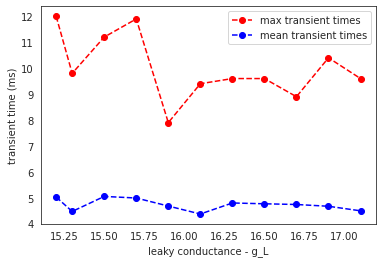

In [25]:
plt.plot(param_set, trans_time_maxs, '--ro', label ='max transient times');
plt.plot(param_set, trans_time_means, '--bo', label='mean transient times');
plt.xlabel('leaky conductance - g_L');
plt.ylabel('transient time (ms)')
plt.legend();

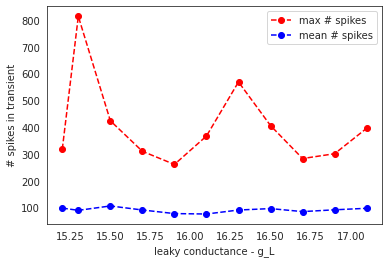

In [26]:
plt.plot(param_set, nspikes_maxs, '--ro', label ='max # spikes');
plt.plot(param_set, nspikes_means, '--bo', label='mean # spikes');
plt.xlabel('leaky conductance - g_L')
plt.ylabel('# spikes in transient')
plt.legend();